![Imgur](https://i.imgur.com/ELdqWFi.png)

<h2 align="center">💸 Falindo o Cassino de Monte Carlo 💸</h2>

Imagine que, após uma bem sucedida corrida no *Circuito de Mônaco*, você decidiu dar uma pausa na adrenalina do asfalto e passar em outra renomada atração turística da cidade, o famoso **Cassino de Monte Carlo**.

Por conta de sua excentricidade e luxúria, os caça-níqueis (às vezes chamados de *one-armed bandits* em inglês) desse cassino funcionavam de uma maneira diferente que a de costume: cada máquina possuía 10 alavancas, com cada alavanca tendo uma certa chance de devolver uma certa quantidade de dinheiro. Como essas máquinas eram muito diferentes daquelas com que você estava acostumado, você decidiu observar um pouco alguns apostadores antes de participar do jogo. Com isso você observou que na média algumas alavancas devolviam mais dinheiro do que outras.

Com sua astúcia, você logo percebeu que poderia aplicar um algoritmo de aprendizado por reforço para conseguir maximizar a quantidade de dinheiro recebida, possivelmente até falindo o cassino.

![Imagem de um k-armed bandit](https://i.imgur.com/TxC4YwW.png)

## Escrevendo a máquina caça-níquel em código

A seguir vamos definir o que seria o ambiente (*enviroment* em inglês) do nosso algoritmo. Nesse caso, ele é a máquina caça-níquel (vamos começar a chamar de *bandit* daqui para frente), na qual você quer aprender qual é a melhor alavanca a se puxar para receber a maior quantidade de dinheiro.

In [3]:
import numpy as np

In [4]:
class Bandit():

    def __init__(self, k_arms=10):
        # gera k números aleatórios uniformemente distribuídos entre -3 e 3
        self.bandits_expectations = np.random.uniform(-3, 3, k_arms)
    
    def gamble(self, action):
        """ação(int) -> recompensa(int)
        Recebe uma ação representando a alavanca que será acionada, 
        que devolve uma recompensa baseada em uma distribuição normal 
        de média definida no init e desvio padrão 1.
        """
        return np.random.normal(self.bandits_expectations[action], 1)

Deixamos o código em orientação a objetos porque é o mais comum para ambientes em Python.
 - `__init__` é o construtor do objeto. Nesse caso ele inicializa o objeto gerando *k* números aleatórios uniformemente distribuídos entre -3 e 3. Cada um desses valores será o valor esperado de retorno de cada alavanca.
 - `gamble` realiza uma das ações possíveis no ambiente e retorna a recompensa obtida. Para cada uma das *k* alavancas o agente pode escolher qual delas irá puxar. Por exemplo, se a ação escolhida for o `0` ele puxará a alavanca de índice `0`, que possui valor esperado definido aleatoriamente pelo `__init__`.

Vamos brincar um pouco com nosso ambiente para entender ele melhor:

In [5]:
np.random.seed(31415)
env = Bandit(5) # inicializa um bandit de 5 alavancas

In [6]:
# Vamos ver os valores esperados de cada uma das alavancas
for i in range(len(env.bandits_expectations)):
  print(f"Alavanca {i} tem valor esperado {env.bandits_expectations[i]}")

Alavanca 0 tem valor esperado 0.8749116354525284
Alavanca 1 tem valor esperado 1.0510450191080096
Alavanca 2 tem valor esperado 2.824223916292027
Alavanca 3 tem valor esperado 2.308826185839571
Alavanca 4 tem valor esperado 2.454395056308611


In [7]:
env.gamble(2) # puxar a alavanca de índice 2

2.770138095051762

## Visualizando as distribuições do Bandit
Por conta de como estão distribuídos os valores esperados, com certeza teremos alguma alavanca que possuí o maior valor esperado. Podemos visualizar isso construindo um gráfico que mostra como os valores estão distribuídos para cada alavanca:

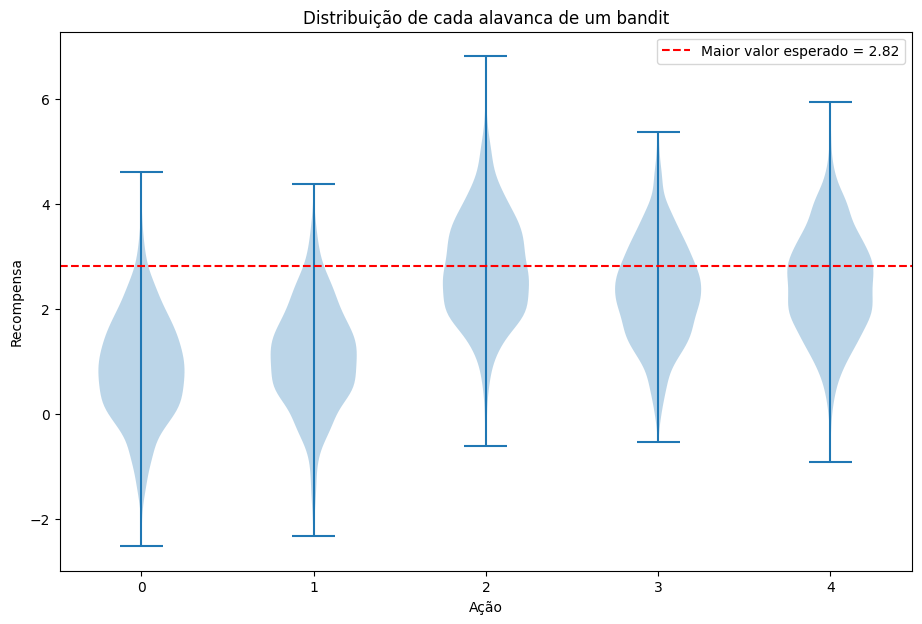

In [8]:
import matplotlib.pyplot as plt

samples = [[env.gamble(0) for i in range(1000)],
           [env.gamble(1) for i in range(1000)],
           [env.gamble(2) for i in range(1000)],
           [env.gamble(3) for i in range(1000)],
           [env.gamble(4) for i in range(1000)]]

plt.figure(figsize=(11,7))

max_e = np.max(env.bandits_expectations)

plt.title("Distribuição de cada alavanca de um bandit")
plt.violinplot(samples, [0,1,2,3,4])
plt.axline((0,max_e), slope=0, ls="--",c="red", label=f"Maior valor esperado = {max_e:.2f}")
plt.legend(loc="best")
plt.xlabel("Ação")
plt.ylabel("Recompensa")
plt.show()        

Assim, com o gráfico podemos ver que realmente, a melhor alavanca a se puxar com o intuito de ganhar a maior quantidade de dinheiro é a de número 2. Porém, como podemos fazer com que o agente aprenda que essa é a melhor alavanca a se puxar também? Veremos isso na próxima seção.

# 🥣 Criando um Algoritmo Guloso (*Greedy*)

## Estimando  o valor esperado *Q*

No nosso problema de $k$-Armed Bandits dizemos que para cada $k$ ações há uma recompensa média esperada; esse valor esperado geralmente é chamado de valor da ação. Ou seja, definimos o valor de uma ação arbitrária $a$, denotado de $q^{*}(a)$, como uma recompensa em um tempo $t$ ($R_t$) dado que a ação em $t$ ($A_t$) foi a como:

$$q^*(a) = \mathbb{E}[R_t | A_t=a]$$

> (Esse $\mathbb{E}$ significa o valor esperado, é como se fosse a “recompensa média” — a recompensa com maior probabilidade de acontecer dado $a$.)

Se nosso agente soubesse todos os valores esperados, o problema seria facilmente resolvido: ele simplesmente escolheria a ação com o maior valor. O problema é justamente que ele não sabe esses valores. Para obter alguma estimativa para esses valores, denotaremos as estimativas com a letra $Q$ maiúscula, já que normalmente em Aprendizado por Reforço nós usamos letras maiúsculas para representar algo aleatório ou um valor estimado.

Como estamos buscando um valor esperado — ou seja, a recompensa média — basta calcularmos a média das recompensas recebidas por nosso agente naquela ação:
$$Q_{n+1} = \frac{1}{n}\sum_{i=1}^{n}R_i$$

Porém, como na computação seria custoso executar uma somatória toda vez que gostaríamos de atualizar Q podemos fazer algumas manipulações algébricas e cair na seguinte equação:
$$Q_{n+1} = Q_n + \frac{1}{n}(R_n - Q_n) $$

Que é a equação que iremos usar em nosso algoritmo! Lembre-se que $n$, nesse caso, vai ser o número de vezes que aquela ação ocorreu. **Então teremos um $n$ e um $Q$ para cada ação**.

## A função argmax

Agora que já sabemos como estimar os valores $Q$ temos que criar alguma função capaz de escolher a ação com o maior valor estimado. Essa é a função argmax!

Ela é definida da seguinte maneira:
 - Recebe uma lista de valores
 - Verifica qual é o maior valor dessa lista
 - Retorna o **índice** desse valor
 - Em caso de empates, ela retorna o índice de um dos maiores valores aleatoriamente

![diagrama da argmax](https://i.imgur.com/B3HJC6P.png)

Seu primeiro exercício será implementar essa função!

### Exercício 1, implementando a função argmax
Complete o código abaixo para implementar a função argmax especificada a cima.

In [9]:
def argmax(Q_values):
    """ (lista) -> índice de maior valor(int)
    Recebe uma lista dos valores Q e retorna o índice do maior valor.
    Por definição, resolve empates escolhendo um deles aleatoriamente.
    """
    max_value = float("-inf")
    ties = []

    for i in range(len(Q_values)):
        if Q_values[i] > max_value:
            max_value = Q_values[i]
            ties.clear()
        if Q_values[i] == max_value:
            ties.append(i)

    return np.random.choice(ties)

# teste = [1, 2, 3, 4, 10, 2, 30, 10, 25, 30, 30, 1]
# print(argmax(teste))
# teste = [4, 14, 3.1, -9, 14, 7.2]
# print(argmax(teste))

## Definindo o agente
Agora que já sabemos como podemos estimar os valores de $Q$ e como podemos escolher as ações de maior valor com a função argmax, podemos definir nosso **agente guloso**. Ele deverá ser composto da seguinte forma:
 - o construtor recebe o número de `k_arms` existentes no ambiente e inicializa os seguintes atributos:
    - `n_arms`: vetor que guardará quantas vezes o agente realizou cada ação. Inicializado com um vetor de zeros com tamanho igual ao número de ações (alavancas).
    - `Q_values`: vetor que armazena o $Q$ valor de cada ação. Inicializado com um vetor de zeros com tamanho igual ao número de ações (alavancas).
    -  `last_action`: última ação do agente. Inicializada com uma ação aleatória.
    
- A função de `step` deve receber a recompensa do episódio e estar definida da seguinte maneira:
   - Atualiza o vetor `n_arms` adicionando mais um ao $n$ da última ação realizada.
   - Calcula o $Q$ atual conforme a fórmula definida.
   - Atualiza o vetor `Q_values` atualizando o novo valor `Q` da última ação.
   - Escolhe a próxima ação passando a lista atualizada de `Q_values` à função argmax.
   - Atualizar a última ação do agente com a ação escolhida.
   - Retorna a ação escolhida.

### Exercício 2, implementando o agente guloso
Complete o código abaixo conforme as definições:

In [10]:
class GreedyAgent():
    def __init__(self, k_arms):
        self.n_arms = np.zeros(k_arms)
        self.Q_values = np.zeros(k_arms)
        self.last_action = np.random.randint(0, k_arms)

    def agent_step(self, reward):
        """ (float) -> acao(int)
        Dá um step para o Agente atualizando os valores Q.
        Pega a recompensas do estado e retorna a ação escolhida.
        """ 

        self.n_arms[self.last_action] += 1
        previous_Q = self.Q_values[self.last_action]
        current_Q = previous_Q + (reward - previous_Q)/self.n_arms[self.last_action]
        self.Q_values[self.last_action] = current_Q

        current_action = argmax(self.Q_values)
        self.last_action = current_action

        return current_action

## Treinando o Agente
Com o agente e o ambiente definidos, podemos finalmente treiná-lo!

O código de treinamento deve ser definido como:
 - Inicializamos nosso agente `agent`, com `k_arms = 10`
 - Inicializamos nosso ambiente `env`, com `k_arms = 10`
 - Para cada `step` no número total de steps  `num_steps`
    - Receber a recompensa do ambiente puxando a alavanca (`env.gamble`) representada pela última ação do agente (`agent.last_action`).
    - Atualizar a estimativa de valor do agente (`agent.agent_step`)

### Exercício 3, implementando o treinamento do agente
Complete o código a baixo conforme as definições:
 

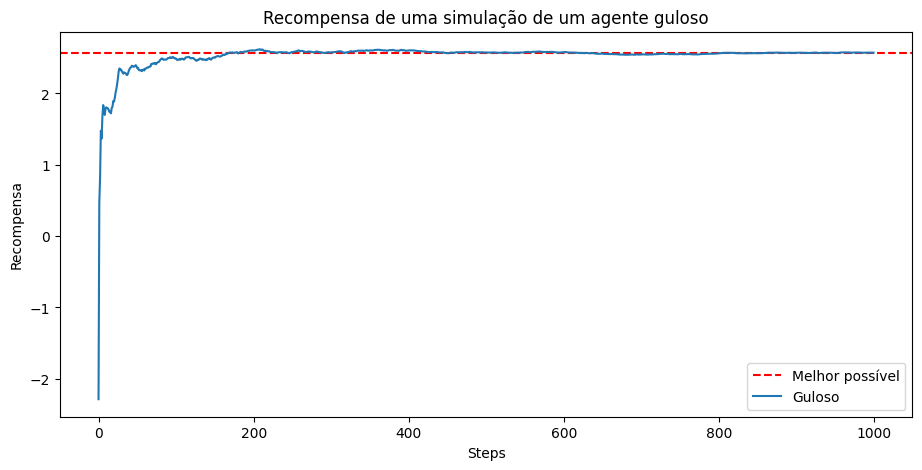

In [11]:
n_steps = 1_000

agent = GreedyAgent(10)
env = Bandit(10)

score = [0]
means = []
max_score = np.max(env.bandits_expectations)

for step in range(n_steps):
    reward = env.gamble(agent.last_action) # Tome ação no ambiente
    
    agent.agent_step(reward) # Atualize a estimativa de valor do agente

    score.append(score[-1] + reward)
    means.append(score[-1]/(step+1))

plt.figure(figsize=(11,5))
plt.title("Recompensa de uma simulação de um agente guloso")
plt.axline((0, max_score), slope=0, ls="--", c="red", label="Melhor possível")
plt.plot(means, label="Guloso")
plt.xlabel("Steps")
plt.ylabel("Recompensa")
plt.legend(loc="best")
plt.show()

Se tudo deu certo você verá o gráfico de uma simulação, com a recompensa comparada com a melhor possível. Você verá que, provavelmente, os resultados não são os melhores, mas existe uma chance de que, por conta de sorte, ele consiga a melhor pontuação. Para eliminar esse fator de sorte podemos executar a simulação várias vezes e pegar a média:

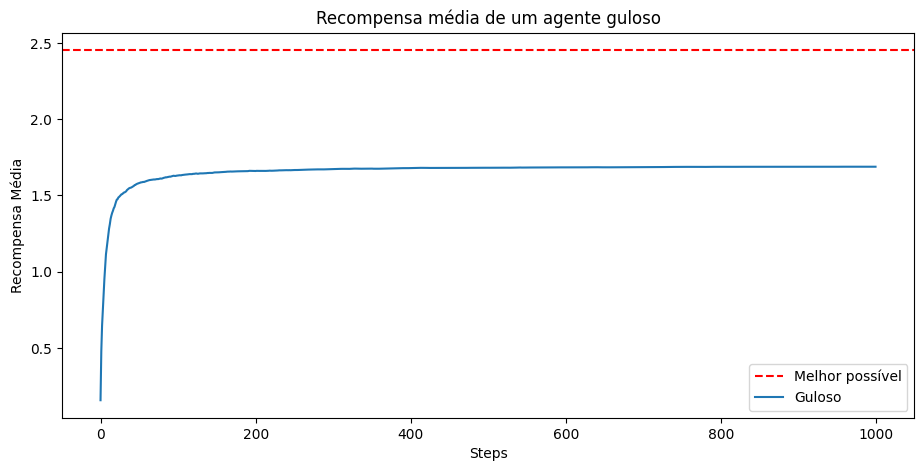

In [12]:
n_steps = 1_000
n_simulations = 200
total_means = []

max_means = 0
for simulation in range(n_simulations):

    agent = GreedyAgent(10)
    env = Bandit(10)

    score = [0]
    means = []

    max_means += np.max(env.bandits_expectations)

    for step in range(n_steps):
        reward = env.gamble(agent.last_action) # Tome ação no ambiente

        agent.agent_step(reward) # Atualize a estimativa de valor do agente

        score.append(score[-1] + reward)
        means.append(score[-1]/(step+1))

    total_means.append(means)

plt.figure(figsize=(11,5))
plt.title("Recompensa média de um agente guloso")
plt.axline((0, max_means/n_simulations), slope=0, ls="--", c="red", label="Melhor possível")
plt.plot(np.mean(total_means, axis=0), label="Guloso")
plt.xlabel("Steps")
plt.ylabel("Recompensa Média")
plt.legend(loc="best")
plt.show()

Por mais que o Algoritmo Guloso consiga chegar rapidamente a uma recompensa média relativamente grande, ele ficará preso a ela para sempre. Por não praticar exploração ele acabará não conhecendo outras ações que podem ser melhores e, na média, ficará preso a uma solução não otimizada.

A solução para isso é o o **Algoritmo ε-Guloso** que possui uma chance aleatória de fazer uma ação de **exploração**!

# 🧭 Criando um Algoritmo ε-Guloso
A ideia de um algoritmo é adicionar um parâmetro $\varepsilon$, que controla a probabilidade do agente realizar uma ação aleatória de exploração. A seguir, discutimos um pouco mais sobre esses dois conceitos.

## Exploração e Explotação

Como no agente guloso nós sempre pegamos a ação de maior valor estimado até aquele momento, é fácil dele cair em soluções subótimas. Para resolver isso, introduzimos a ideia de **exploração** no algoritmo.

A exploração é uma maneira do agente identificar cenários ainda não vistos, conhecendo melhor o valor de cada ação. A explotação, por sua vez, é utilizar esse conhecimento para tomar a melhor decisão. Uma analogia com o mundo real seria o menu de um restaurante: imagine que você pediu um prato lá e acabou gostando deste prato, você poderia sempre pedi-lo quando fosse nesse restaurante e acabaria feliz, porém, se não se arriscar a pedir nenhum outro prato nunca saberá se pode haver um prato do qual você acabe gostando mais!

## Definindo o Agente
No geral, o agente $\varepsilon$-guloso é bem parecido com o agente guloso, a maior diferença sendo a presença desse novo parâmetro $\varepsilon$ e a chance $\varepsilon$ dele executar uma ação aleatória ao invés da de maior valor estimado.

Com isso o código ficaria definido como:
 - No construtor, além do parâmetro `k_arms`, agora ele deve receber o parâmetro `epsilon`.
    - Além dos atributos já definidos no agente guloso, agora ele também deve inicializar um atributo `self.epsilon` que armazena o valor de `epsilon`
 - Na função de `step` todos os passos de atualização dos vetores continuam os mesmos, o que muda é agora colocar a chance de executar uma ação aleatória
    - Ao invés de só escolher a próxima ação com base no argmax você deve gerar um número real aleatório entre 0 e 1.
    - Se esse número for menor que o epsilon, a próxima ação deve ser aleatória (um número inteiro aleatório entre 0 e número de braços-1)
    - Se não, a próxima ação é a com maior $Q$ valor (passando a lista de valores $Q$ na argmax).

### Exercício 4, implementado o agente ε-Guloso

In [13]:
class EpsilonGreedy():
    def __init__(self, k_arms, epsilon=0.1):
        self.epsilon = epsilon
        self.n_arms = np.zeros(k_arms)
        self.Q_values = np.zeros(k_arms)
        self.last_action = np.random.randint(0, k_arms)

    def agent_step(self, reward):
        """ (float) -> acao(int)
        Dá um step para o Agente atualizando os valores Q.
        Pega a recompensas do estado e retorna a ação escolhida.
        """ 

        self.n_arms[self.last_action] += 1
        previous_Q = self.Q_values[self.last_action]
        current_Q = previous_Q + (reward - previous_Q)/self.n_arms[self.last_action]
        self.Q_values[self.last_action] = current_Q

        u = np.random.random() # número aleatório real entre 0 e 1

        if u < self.epsilon:
            current_action = np.random.random_integers(0, len(self.n_arms) - 1)
        else:
            current_action = argmax(self.Q_values)

        self.last_action = current_action

        return current_action

## Treinando o Agente
O processo de treinamento é o mesmo, o único diferencial é que agora podemos testar diferentes resultados para diferentes valores de $\varepsilon$.
 - Lembre-se de inicializar o agente e o ambiente. Para o agente, lembre de passar o parâmetro de `epsilon=eps`.
 - Dentro da lista `epsilons` escreva alguns valores para o parâmetro. Recomendamos três em específico: 0.1, 0.5 e 0 (se `epsilon = 0` então é só o algoritmo guloso), mas sinta-se livre para experimentar mais parâmetros.
 - Como foram os resultados obtidos? Qual é a relação de mudar o valor de $\varepsilon$ e a média das recompensas médias?
 - Sinta-se livre para também testar valores de $\varepsilon$ bem pequenos (0.01 por exemplo) e também aumentar o número de steps.

C:\Users\Vitor Sasaki\AppData\Local\Temp\ipykernel_13492\1975586872.py:22: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead
  current_action = np.random.random_integers(0, len(self.n_arms) - 1)


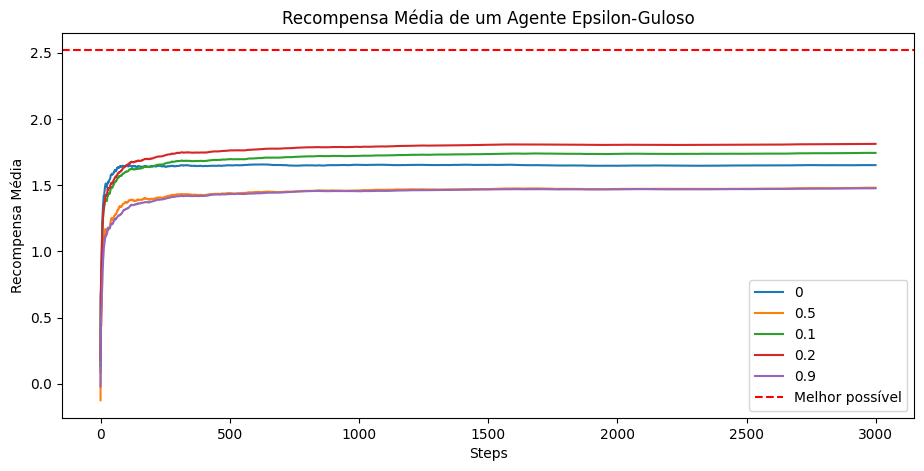

In [16]:
n_steps = 3_000
n_simulations = 20
total_means = []
max_means = []

# coloque outros parâmetros para epsilon!
epsilons = [0, 0.5, 0.1, 0.2, 0.9]

plt.figure(figsize=(11,5))

# Fazer 20 simulações, com 3.000 steps para cada epsilon eps
for eps in epsilons: 
    max_mean = 0
    for runs in range(n_simulations):

        agent = EpsilonGreedy(10, eps) # inicialize o agente com um epsilon diferente

        env = Bandit(10) 

        score = [0]
        means = []

        max_mean += np.max(env.bandits_expectations)

        for step in range(n_steps):
            reward = env.gamble(agent.last_action) # Tome ação no ambiente

            agent.agent_step(reward) # Atualize a estimativa de valor do agente

            score.append(score[-1] + reward)
            means.append(score[-1]/(step+1))
        total_means.append(means)

    max_means.append(max_mean/n_simulations)
    
    plt.plot(np.mean(total_means, axis=0), label=f"{eps}")

y = np.mean(max_means, 0)
plt.axline((0, y), slope=0, ls="--", c="red", label="Melhor possível")
plt.legend(loc="best")
plt.title("Recompensa Média de um Agente Epsilon-Guloso")
plt.xlabel("Steps")
plt.ylabel("Recompensa Média")
plt.show()

Parabéns piloto! Se tudo deu certo você conseguirá ver os resultados do seu modelo, que mostram como essa simples mudança consegue, após um certo número de iterações, melhores resultados que um mero agente guloso!

Agora, com seu modelo criado, você está pronto para faturar milhões no cassino de Monte Carlo, para depois gastar todo esse dinheiro em ***🍦 sorvetinhos 🍦 ***, obviamente.

> Caso esteja interessado, você pode olhar também mais duas implementações que obtém resultados ainda melhores!
 - Bandits com [função softmax](https://github.com/turing-usp/Aprendizado-por-Reforco/tree/main/Aprendizado%20por%20Refor%C3%A7o%20Cl%C3%A1ssico/Bandits/SoftMax) que calculam um valor de *preferência* de uma ação.
 - Bandits com [limite de confiança superior](https://github.com/turing-usp/Aprendizado-por-Reforco/tree/main/Aprendizado%20por%20Refor%C3%A7o%20Cl%C3%A1ssico/Bandits/Limite%20de%20Confian%C3%A7a%20Superior) que utiliza um parâmetro de confiança para explorar e explotar.
 - Para um formalismo maior, você também pode ler o capítulo de Bandits no fantástico livro do [Sutton & Barton](https://web.archive.org/web/20210608124316/https://incompleteideas.net/book/RLbook2020.pdf) referência principal em Aprendizado por Reforço.